In [2]:
import sys
from pathlib import Path
import pandas as pd
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from pymongo import MongoClient

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
load_dotenv(dotenv_path=os.path.abspath("../.env"))  # hoặc đường dẫn tuyệt đối đến file .env


# 2. Lấy thông tin cấu hình
user = os.getenv("MONGO_USER")
pw = os.getenv("MONGO_PASS")
cluster = os.getenv("MONGO_CLUSTER")
db_name = os.getenv("MONGO_DB")
col_name = os.getenv("MONGO_COLLECTION")

# 3. Tạo chuỗi kết nối URI
uri = f"mongodb+srv://{user}:{pw}@{cluster}/?retryWrites=true&w=majority"

# 4. Kết nối và lấy dữ liệu trực tiếp vào DataFrame
try:
    client = MongoClient(uri)
    db = client[db_name]
    col = db[col_name]
    
    # Lấy toàn bộ dữ liệu (bỏ cột _id của MongoDB để tránh lỗi định dạng khi phân tích)
    data = list(col.find({}, {"_id": 0}))
    
    # Chuyển thành DataFrame để bắt đầu EDA
    df = pd.DataFrame(data)
    df = pd.json_normalize(data, sep=".")
    
    print(f"Đã kết nối tới Database: {db_name}, Collection: {col_name}")
    print(f"Số lượng bản ghi thu thập được: {len(df)}")
    
except Exception as e:
    print(f"Kết nối thất bại: {e}")

Đã kết nối tới Database: batdongsanvn, Collection: properties_post
Số lượng bản ghi thu thập được: 32794


# Tổng quan dữ liệu

In [3]:
df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   post_id                       5 non-null      object 
 1   property_url                  5 non-null      object 
 2   transaction_type              5 non-null      object 
 3   property_category             5 non-null      object 
 4   title                         5 non-null      object 
 5   address                       5 non-null      object 
 6   latitude                      5 non-null      float64
 7   longitude                     5 non-null      float64
 8   price                         5 non-null      object 
 9   price_per_spm                 5 non-null      object 
 10  area                          5 non-null      object 
 11  description                   5 non-null      object 
 12  images                        5 non-null      object 
 13  date_post

In [4]:
df.columns.tolist()

['post_id',
 'property_url',
 'transaction_type',
 'property_category',
 'title',
 'address',
 'latitude',
 'longitude',
 'price',
 'price_per_spm',
 'area',
 'description',
 'images',
 'date_posted',
 'date_expired',
 'news_type',
 'verified',
 'scraped_at',
 'spec.bedroom',
 'spec.bathroom',
 'spec.legal',
 'spec.furniture',
 'project_info.name',
 'project_info.status',
 'project_info.investor',
 'project_info.image',
 'project_info.project_url',
 'project_info.listing_count',
 'contact_info.name',
 'contact_info.profile_url',
 'contact_info.avatar_url',
 'contact_info.phone_invisible',
 'contact_info.zalo_url',
 'contact_info.join_duration',
 'contact_info.listings',
 'spec.front_width',
 'spec.road_width',
 'spec.num_floor',
 'project_info.price',
 'spec.orientation',
 'spec.balcony_direction',
 'spec.exdate',
 'spec.electricity',
 'spec.water',
 'spec.internet',
 'spec.utilities',
 'verified_status']

# Xử lý dữ liệu cơ bản trước khi trực quan

## xử lý trùng lặp

In [5]:

# Giả sử df_sale là DataFrame chứa dữ liệu
duplicates = (
    df.groupby(["address", "area", "price"])
    .agg(count=("post_id", "count"), posts=("post_id", list))
    .reset_index()
)

# Lọc ra những nhóm có nhiều hơn 1 tin
duplicates = duplicates[duplicates["count"] > 1]

print(duplicates)


                                                 address    area  \
113    125/2 Đường Thới An 20, Phường Thới An, Quận 1...   64 m²   
246    173.75 Đường Hoàng Hoa Thám, Phường Liễu Giai...  191 m²   
254      179, Đường 3/2, Phường 11, Quận 10, Hồ Chí Minh   64 m²   
298    19/25, Đường 8, Phường Linh Trung, Thủ Đức, Hồ...   16 m²   
523    28, Đường Ấp Bắc, Phường 13, Tân Bình, Hồ Chí ...  336 m²   
...                                                  ...     ...   
31404      Đường Đồng Trạng, Xã Cổ Đông, Sơn Tây, Hà Nội  100 m²   
31426   Đường Đỗ Bá, Phường Mỹ An, Ngũ Hành Sơn, Đà Nẵng  140 m²   
31427   Đường Đỗ Bá, Phường Mỹ An, Ngũ Hành Sơn, Đà Nẵng  140 m²   
31476  Đường Đỗ Đức Dục, Phường Mễ Trì, Nam Từ Liêm, ...   35 m²   
31613  đường Mỹ Đình, Phường Mỹ Đình 1, Nam Từ Liêm, ...   20 m²   

                 price  count                 posts  
113     12 triệu/tháng      2  [44825847, 44561628]  
246            47,9 tỷ      2  [44822590, 44878600]  
254     65 triệu/thán

In [6]:
# Giữ lại duy nhất 1 dòng cho mỗi bất động sản, xóa các dòng trùng lặp
df = df.drop_duplicates(
    subset=["address", "area", "price"],
    keep="first"   # giữ lại dòng đầu tiên, có thể đổi thành "last"
)


## chia thành các df nhỏ để tiện xử lý riêng

In [7]:
df_sale = df[df["transaction_type"] == "sale"]
df_rent = df[df["transaction_type"] == "rent"].drop(columns=["price_per_spm"])

In [8]:
def convert_area_vietnamese_standard(x):
    if pd.isna(x): return np.nan
    
    # 1. Chuyển sang chuỗi, viết thường và xóa khoảng trắng
    text = str(x).lower().strip()
    
    # 2. Xóa các đơn vị diện tích (m2, m², mét vuông...)
    text = re.sub(r'(m2|m²|mét vuông|met vuong|m).*', '', text).strip()
    
    try:
        # 3. QUY TẮC VÀNG:
        # - Xóa dấu chấm (hàng nghìn): 1.000 -> 1000
        # - Thay dấu phẩy bằng dấu chấm (thập phân): 50,5 -> 50.5
        text = text.replace('.', '')
        text = text.replace(',', '.')
        
        # 4. Chuyển về số thực
        val = float(text)
        return val
    except:
        return np.nan

# Áp dụng cho dataframe
df['area'] = df['area'].apply(convert_area_vietnamese_standard)

# Loại bỏ những dòng không có diện tích hợp lệ (nếu cần)
df = df.dropna(subset=['area'])

print("Đã cập nhật diện tích theo quy tắc: [.] hàng nghìn, [,] thập phân.")

Đã cập nhật diện tích theo quy tắc: [.] hàng nghìn, [,] thập phân.


In [9]:
def split_address(addr):
    if pd.isna(addr): return None, None, None
    parts = [p.strip() for p in str(addr).split(',')]
    province = parts[-1] if len(parts) >= 1 else None
    district = parts[-2] if len(parts) >= 2 else None
    ward = parts[-3] if len(parts) >= 3 else None
    return ward, district, province

df[['ward', 'district', 'province']] = df['address'].apply(lambda x: pd.Series(split_address(x)))

In [10]:
df['province'].unique()

array(['Hồ Chí Minh', 'Phú Thọ', 'Hà Nội', 'Đồng Nai', 'Bình Dương',
       'Hưng Yên', 'Long An', 'Đà Nẵng', 'Hải Phòng', 'Vĩnh Phúc',
       'Nam Định', 'Bà Rịa Vũng Tàu', 'Khánh Hòa', 'Hòa Bình', 'Hà Nam',
       'Lâm Đồng', 'Đà Nẵng.', 'Thanh Hóa', 'Bình Dương.', 'Bắc Ninh',
       'Thừa Thiên Huế', 'Hải Dương', 'Quảng Ninh', 'Hồ Chí Minh.',
       'Quảng Nam', 'Thành phố Hồ Chí Minh.', 'Long An.', 'Bình Thuận',
       'Bình Phước', 'Nghệ An', 'phường Hiệp Bình Chánh', 'số nhà 48 CT',
       'Phú Yên', 'Kiên Giang', 'Tp. Hồ Chí Minh', 'Tây Ninh',
       'An Zen Residences', 'Thái Nguyên', 'Bình Định', 'Bắc Giang',
       'Đắk Lắk', 'Phú Cát', 'Ninh Bình', 'Phường Bàn Thạch - TP Đà Nẵng',
       'Đắk Nông', 'Thái Bình', 'Hà Nội.', 'Tp Hồ Chí Minh', 'TP Đà Nẵng',
       'Quảng Bình', 'TpHCM', '33 Lê Văn Lương', 'Đồng Tháp', 'Cần Thơ',
       'Hậu Giang', 'Hồ Chí Mịnh', 'Gia Lai', 'xã Tân Định )',
       'Tiền Giang', 'Đồng Naii', 'Ninh Thuận', 'Xã Láng Dài',
       'xã đông hội đông 

In [11]:
# chuyển cột date_posted về dạng datetime
df["date_posted"] = pd.to_datetime(df["date_posted"], errors="coerce", dayfirst=True)


In [12]:
df_rent = df[df["transaction_type"] == "rent"].copy()
df_sale = df[df["transaction_type"] == "sale"].copy()

In [13]:
def convert_price_sale(x):
    if pd.isna(x): return np.nan, "valid"
    text = str(x).lower().strip().replace(",", ".")
    if "thỏa thuận" in text: return np.nan, "negotiable"
    
    try:
        match = re.search(r"(\d+\.?\d*)", text)
        if not match or "/m" in text: return np.nan, "error" # Xóa dòng có /m2 trong giá tổng
        
        num = float(match.group(1))
        if "tỷ" in text: return num * 1000, "valid"
        if "triệu" in text: return num, "valid"
        return num, "valid"
    except:
        return np.nan, "error"

res_sale = df_sale["price"].apply(convert_price_sale)
df_sale["price"] = [x[0] for x in res_sale]
df_sale["price_status"] = [x[1] for x in res_sale]

# Xóa dòng lỗi giá ở df_sale
df_sale = df_sale[df_sale["price_status"] != "error"].drop(columns=["price_status"])

In [14]:
def convert_price_rent(x):
    if pd.isna(x): return np.nan, "valid"
    text = str(x).lower().strip().replace(",", ".")
    if "thỏa thuận" in text: return np.nan, "negotiable"
    
    try:
        # Lấy số đầu tiên (thường là triệu)
        match = re.findall(r"(\d+\.?\d*)", text)
        if not match: return np.nan, "error"
        
        return float(match[0]), "valid"
    except:
        return np.nan, "error"

res_rent = df_rent["price"].apply(convert_price_rent)
df_rent["price"] = [x[0] for x in res_rent]
df_rent["price_status"] = [x[1] for x in res_rent]

# Xóa dòng lỗi giá ở df_rent
df_rent = df_rent[df_rent["price_status"] != "error"].drop(columns=["price_status"])

In [15]:
# tính cột price_per_spm
df_sale["price_per_spm"] = df_sale["price"] / df_sale["area"]


In [16]:
df_rent['price'].describe()

count    12415.000000
mean        48.109910
std         88.888491
min          1.000000
25%          8.000000
50%         16.000000
75%         44.000000
max        990.000000
Name: price, dtype: float64

# TRỰC QUAN

## Phân tích vấn đề dữ liệu null

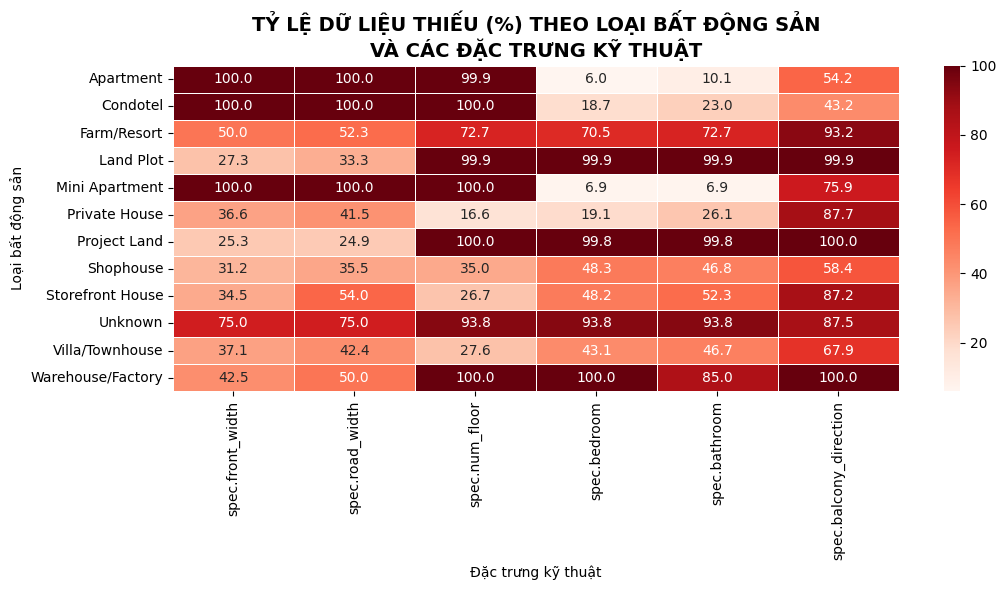


Nhận xét:
- Dữ liệu thiếu không xuất hiện ngẫu nhiên mà phụ thuộc mạnh vào loại bất động sản.
- Các đặc trưng như bedroom, bathroom, num_floor bị thiếu gần như hoàn toàn ở nhóm đất nền,
  do loại hình này không có đặc điểm phòng ở.
- Front_width và road_width thường xuất hiện ở nhà riêng và đất nền,
  nhưng lại thiếu ở căn hộ chung cư.
- Nhóm Unknown có tỷ lệ thiếu cao ở hầu hết các đặc trưng, phản ánh chất lượng dữ liệu thấp.

Kết luận:
Dữ liệu thiếu phản ánh bản chất của từng loại bất động sản thay vì là lỗi thu thập.
Việc xử lý dữ liệu và phân tích cần được thực hiện theo từng loại hình cụ thể.



In [17]:
# =========================================================
# PHÂN TÍCH MỐI QUAN HỆ GIỮA DỮ LIỆU THIẾU (NULL)
# VÀ LOẠI HÌNH BẤT ĐỘNG SẢN
# =========================================================

# 1. Chọn các đặc trưng kỹ thuật cần phân tích NULL
spec_cols = [
    'spec.front_width',
    'spec.road_width',
    'spec.num_floor',
    'spec.bedroom',
    'spec.bathroom',
    'spec.balcony_direction'
]

# 2. Tạo DataFrame đánh dấu NULL (1 = thiếu, 0 = có)
null_df = df_sale[['property_category'] + spec_cols].copy()
for col in spec_cols:
    null_df[col] = null_df[col].isnull().astype(int)

# 3. Tính tỷ lệ NULL (%) theo loại bất động sản
null_rate_by_type = (
    null_df
    .groupby('property_category')[spec_cols]
    .mean()
    .mul(100)
    .round(1)
)

# 4. Vẽ heatmap NULL × Loại BĐS
plt.figure(figsize=(11, 6))
sns.heatmap(
    null_rate_by_type,
    annot=True,
    fmt='.1f',
    cmap='Reds',
    linewidths=0.5
)
plt.title(
    'TỶ LỆ DỮ LIỆU THIẾU (%) THEO LOẠI BẤT ĐỘNG SẢN\n'
    'VÀ CÁC ĐẶC TRƯNG KỸ THUẬT',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('Loại bất động sản')
plt.xlabel('Đặc trưng kỹ thuật')
plt.tight_layout()
plt.show()

# 5. In phần nhận xét ngắn gọn (thay cho markdown riêng)
print("""
Nhận xét:
- Dữ liệu thiếu không xuất hiện ngẫu nhiên mà phụ thuộc mạnh vào loại bất động sản.
- Các đặc trưng như bedroom, bathroom, num_floor bị thiếu gần như hoàn toàn ở nhóm đất nền,
  do loại hình này không có đặc điểm phòng ở.
- Front_width và road_width thường xuất hiện ở nhà riêng và đất nền,
  nhưng lại thiếu ở căn hộ chung cư.
- Nhóm Unknown có tỷ lệ thiếu cao ở hầu hết các đặc trưng, phản ánh chất lượng dữ liệu thấp.

Kết luận:
Dữ liệu thiếu phản ánh bản chất của từng loại bất động sản thay vì là lỗi thu thập.
Việc xử lý dữ liệu và phân tích cần được thực hiện theo từng loại hình cụ thể.
""")


## DASHBOARD chung

C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\1344063496.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='transaction_type', ax=axes[0, 0], palette=['#3498db', '#e74c3c'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\1344063496.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='transaction_type', y='area', ax=axes[0, 1], palette=['#3498db', '#e74c3c'], errorbar=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\1344063496.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=verified_rate.index, y=v

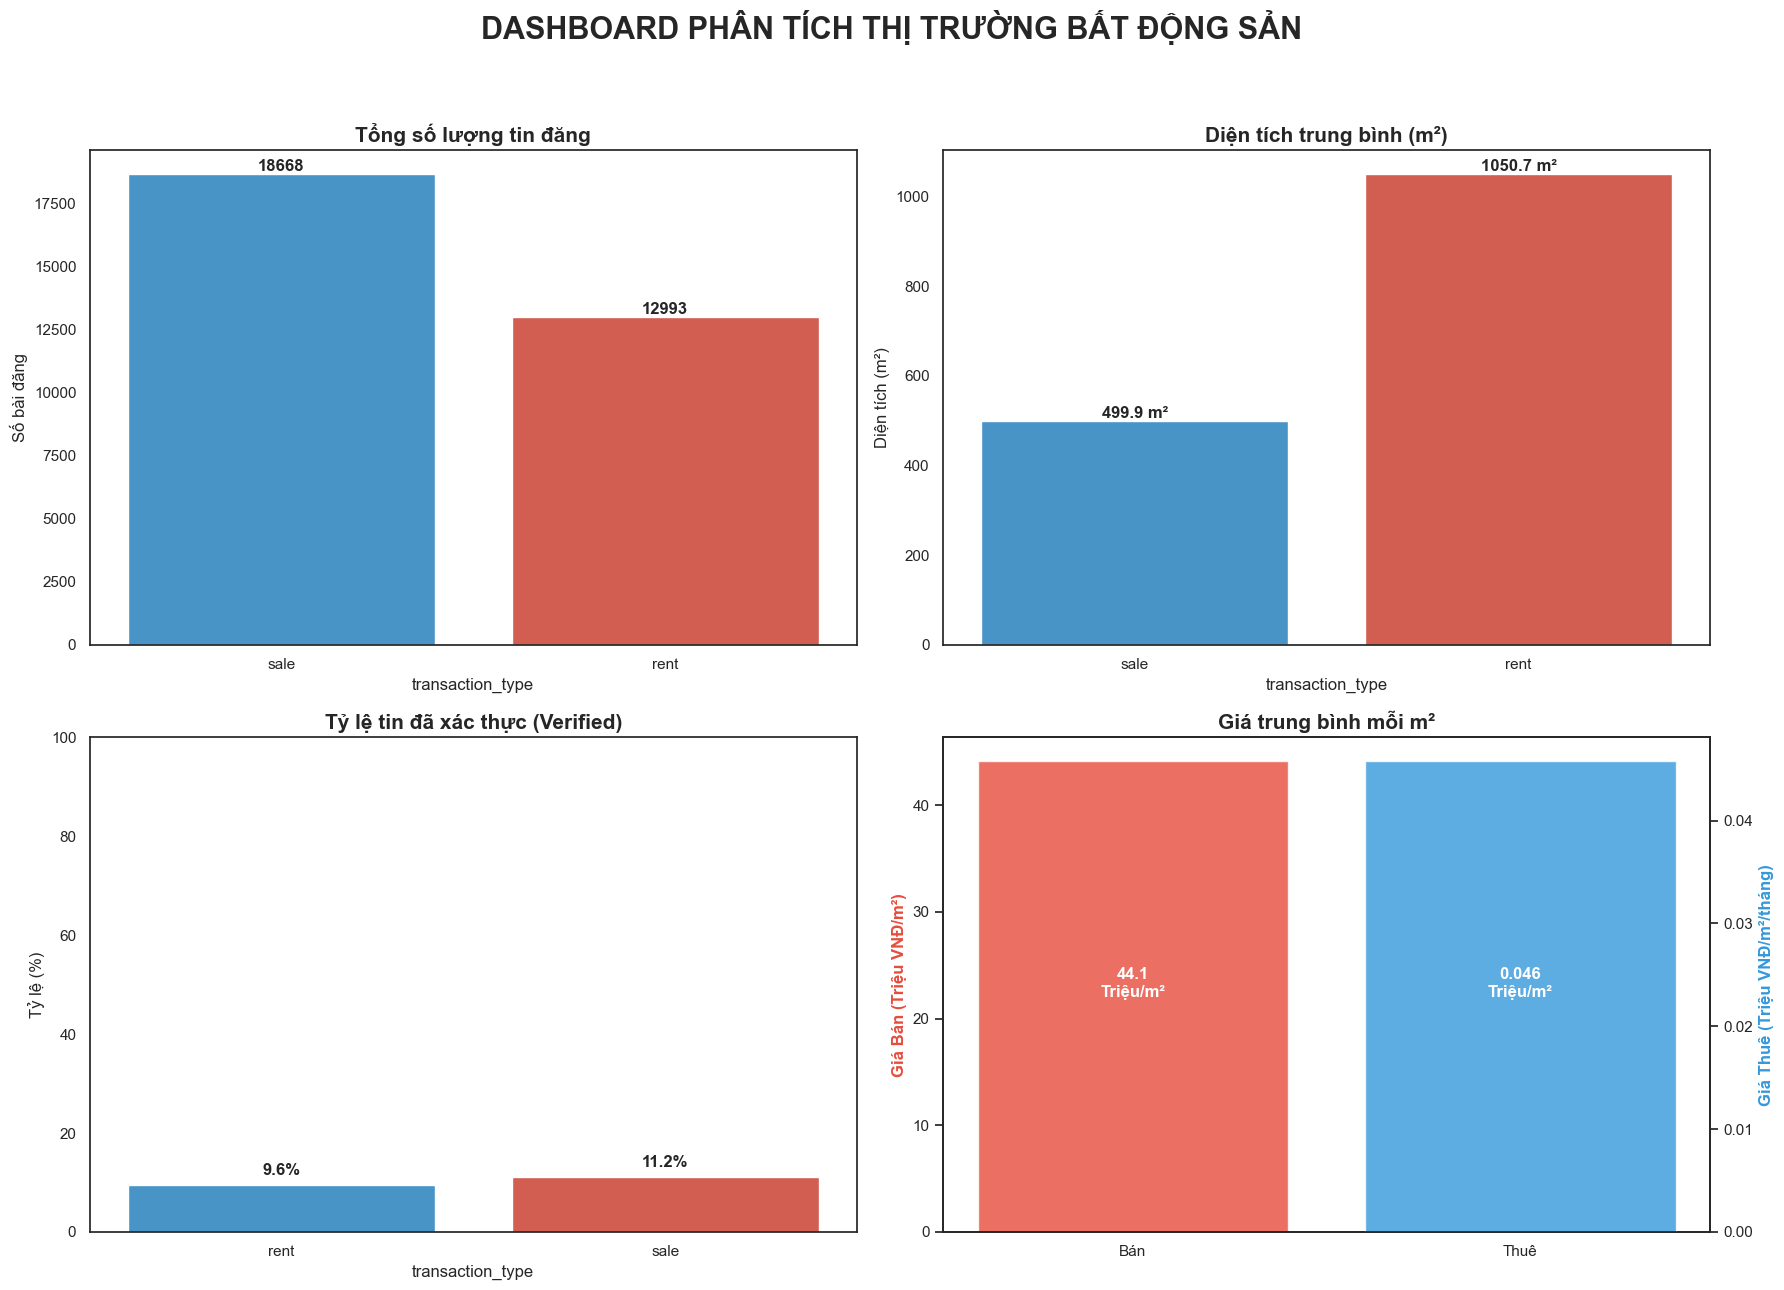

In [18]:

# Thiết lập thông số chung
sns.set_theme(style="white")
plt.rcParams['font.sans-serif'] = ['Arial'] # Đảm bảo hiển thị tốt

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('DASHBOARD PHÂN TÍCH THỊ TRƯỜNG BẤT ĐỘNG SẢN', fontsize=22, fontweight='bold', y=0.95)

# --- 1. TỔNG SỐ TIN ĐĂNG (GỘP) ---
sns.countplot(data=df, x='transaction_type', ax=axes[0, 0], palette=['#3498db', '#e74c3c'])
axes[0, 0].set_title('Tổng số lượng tin đăng', fontsize=15, fontweight='bold')
axes[0, 0].set_ylabel('Số bài đăng')
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- 2. DIỆN TÍCH TRUNG BÌNH (GỘP) ---
sns.barplot(data=df, x='transaction_type', y='area', ax=axes[0, 1], palette=['#3498db', '#e74c3c'], errorbar=None)
axes[0, 1].set_title('Diện tích trung bình (m²)', fontsize=15, fontweight='bold')
axes[0, 1].set_ylabel('Diện tích (m²)')
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.1f} m²', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- 3. TỶ LỆ TIN ĐÃ XÁC THỰC (GỘP) ---
verified_rate = df.groupby('transaction_type')['verified'].mean() * 100
sns.barplot(x=verified_rate.index, y=verified_rate.values, ax=axes[1, 0], palette=['#3498db', '#e74c3c'])
axes[1, 0].set_title('Tỷ lệ tin đã xác thực (Verified)', fontsize=15, fontweight='bold')
axes[1, 0].set_ylabel('Tỷ lệ (%)')
axes[1, 0].set_ylim(0, 100)
for i, v in enumerate(verified_rate.values):
    axes[1, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# --- 4. GIÁ TRUNG BÌNH/M2 (TÁCH BIỆT BẰNG TRỤC Y PHỤ) ---
# Tính toán giá m2 cho từng loại
rent_price_m2 = df_rent['price'].mean() / df_rent['area'].mean()
sale_price_m2 = df_sale['price'].mean() / df_sale['area'].mean()

ax4_left = axes[1, 1]
ax4_right = ax4_left.twinx()

# Vẽ cột cho Bán (Trục trái)
bar1 = ax4_left.bar(['Bán'], [sale_price_m2], color='#e74c3c', alpha=0.8, label='Giá Bán')
# Vẽ cột cho Thuê (Trục phải)
bar2 = ax4_right.bar(['Thuê'], [rent_price_m2], color='#3498db', alpha=0.8, label='Giá Thuê')

ax4_left.set_title('Giá trung bình mỗi m²', fontsize=15, fontweight='bold')
ax4_left.set_ylabel('Giá Bán (Triệu VNĐ/m²)', color='#e74c3c', fontweight='bold')
ax4_right.set_ylabel('Giá Thuê (Triệu VNĐ/m²/tháng)', color='#3498db', fontweight='bold')

# Thêm nhãn giá trị trực tiếp
ax4_left.text(0, sale_price_m2/2, f'{sale_price_m2:.1f}\nTriệu/m²', ha='center', color='white', fontweight='bold')
ax4_right.text(1, rent_price_m2/2, f'{rent_price_m2:.3f}\nTriệu/m²', ha='center', color='white', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

## Cơ cấu phân khúc bất động sản

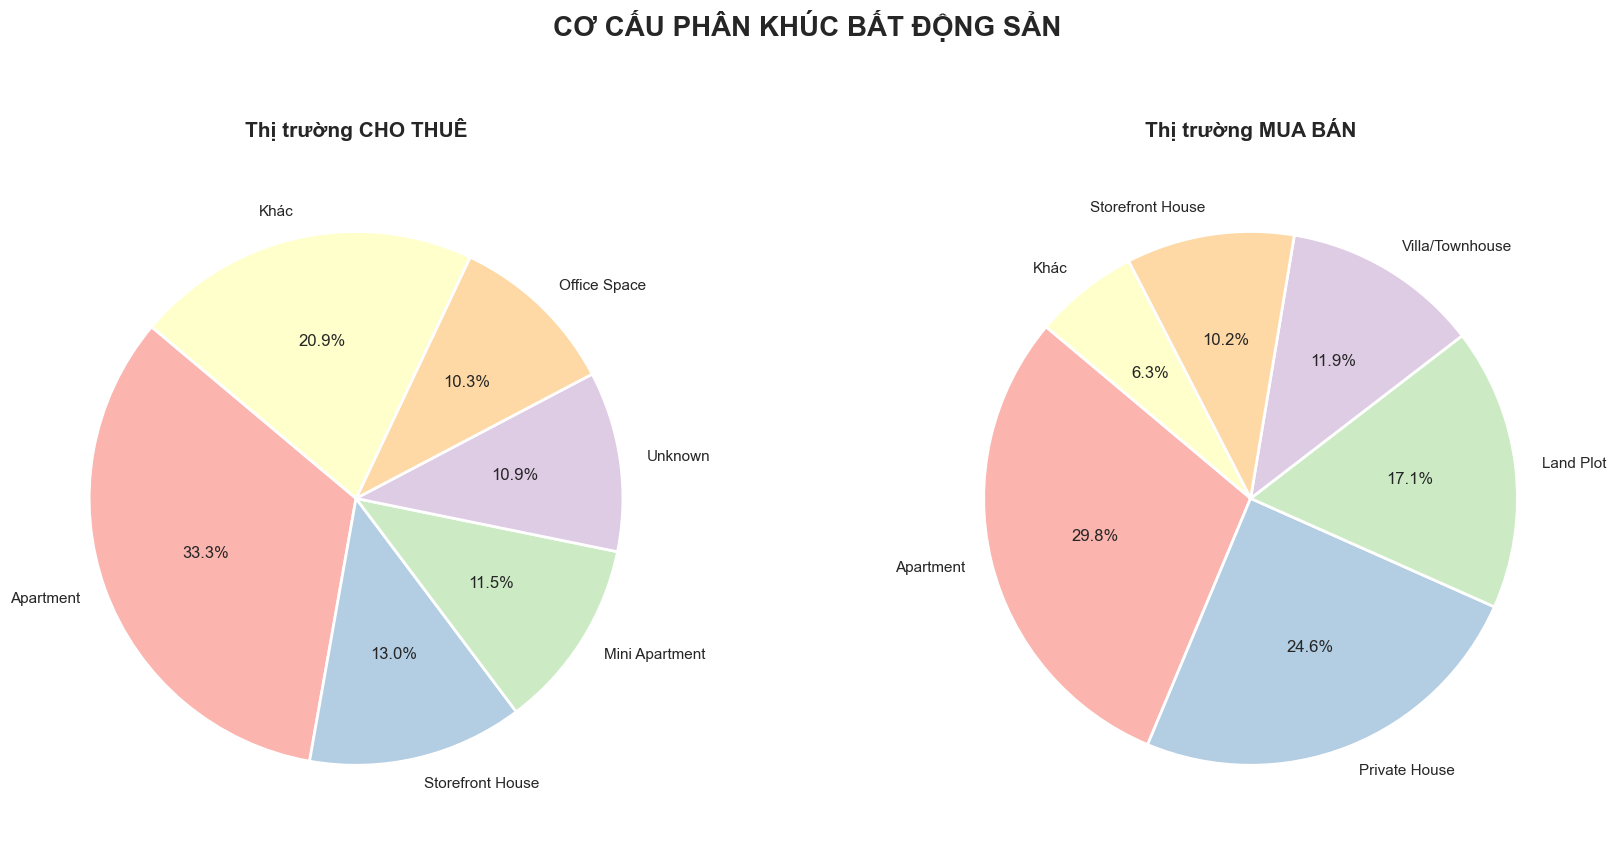

In [19]:


# 1. Chuẩn bị dữ liệu (Lấy top 5 loại hình phổ biến nhất, còn lại gộp vào 'Khác')
def get_category_counts(df, top_n=5):
    counts = df['property_category'].value_counts()
    if len(counts) > top_n:
        top_counts = counts[:top_n]
        others_count = counts[top_n:].sum()
        top_counts['Khác'] = others_count
        return top_counts
    return counts

rent_categories = get_category_counts(df_rent)
sale_categories = get_category_counts(df_sale)

# 2. Thiết lập màu sắc (Sử dụng bảng màu Pastel để dễ nhìn)
colors = plt.get_cmap('Pastel1').colors

# 3. Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('CƠ CẤU PHÂN KHÚC BẤT ĐỘNG SẢN', fontsize=20, fontweight='bold', y=1.05)

# Biểu đồ cho Thuê
ax1.pie(rent_categories, labels=rent_categories.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax1.set_title('Thị trường CHO THUÊ', fontsize=15, fontweight='bold', pad=20)

# Biểu đồ cho Bán
ax2.pie(sale_categories, labels=sale_categories.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax2.set_title('Thị trường MUA BÁN', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## Phân phối giá thuê và bán

In [20]:

def plot_dist_with_boxplot(data, title, color, unit):
    # Tạo khung với 2 phần: Boxplot nhỏ ở trên và Histogram ở dưới
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)}, 
                                        figsize=(12, 7))
    
    # 1. Vẽ Boxplot
    sns.boxplot(x=data, ax=ax_box, color=color, fliersize=4)
    ax_box.set(xlabel='')
    ax_box.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # 2. Vẽ Histogram + Đường KDE (đường cong mật độ)
    sns.histplot(x=data, ax=ax_hist, kde=True, color=color, bins=50)
    ax_hist.set_xlabel(f'Giá ({unit})', fontsize=12)
    ax_hist.set_ylabel('Số lượng bài đăng', fontsize=12)
    
    # Loại bỏ khung thừa để nhìn sạch hơn
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.tight_layout()
    plt.show()

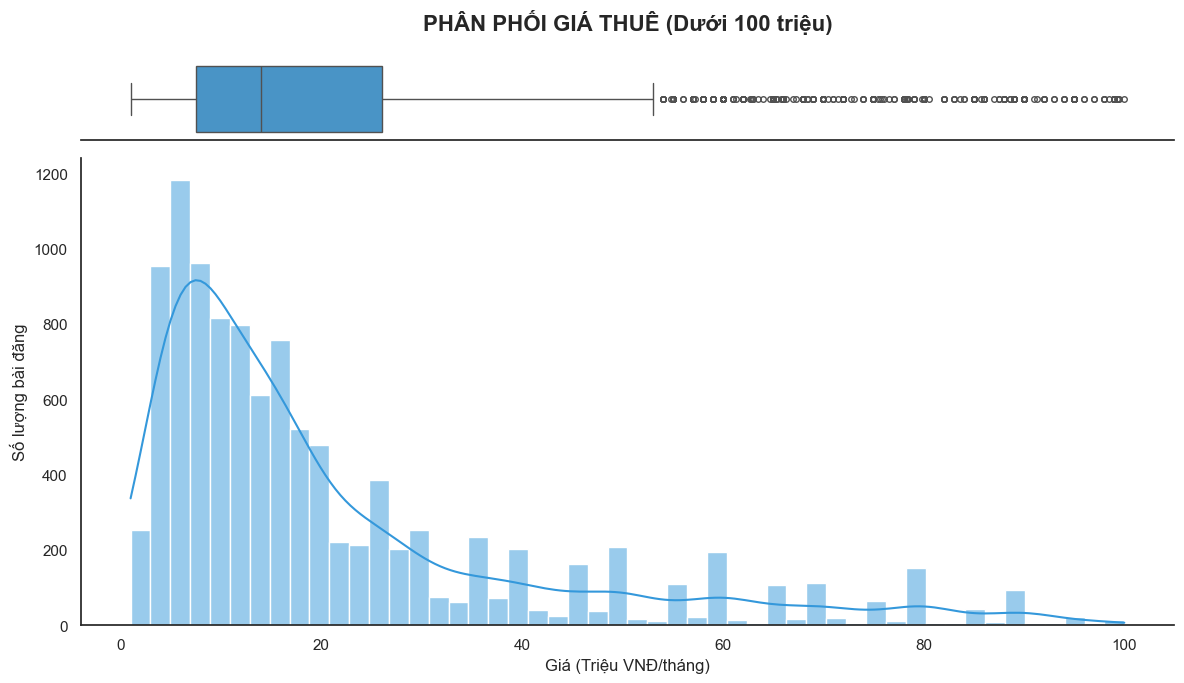

In [21]:
# Thông thường giá thuê tập trung dưới 100 triệu, ta có thể lọc để biểu đồ không bị kéo quá dài bởi 1 vài tin cực lớn
rent_prices = df_rent[df_rent['price'] < 100]['price'].dropna()
plot_dist_with_boxplot(rent_prices, 'PHÂN PHỐI GIÁ THUÊ (Dưới 100 triệu)', '#3498db', 'Triệu VNĐ/tháng')

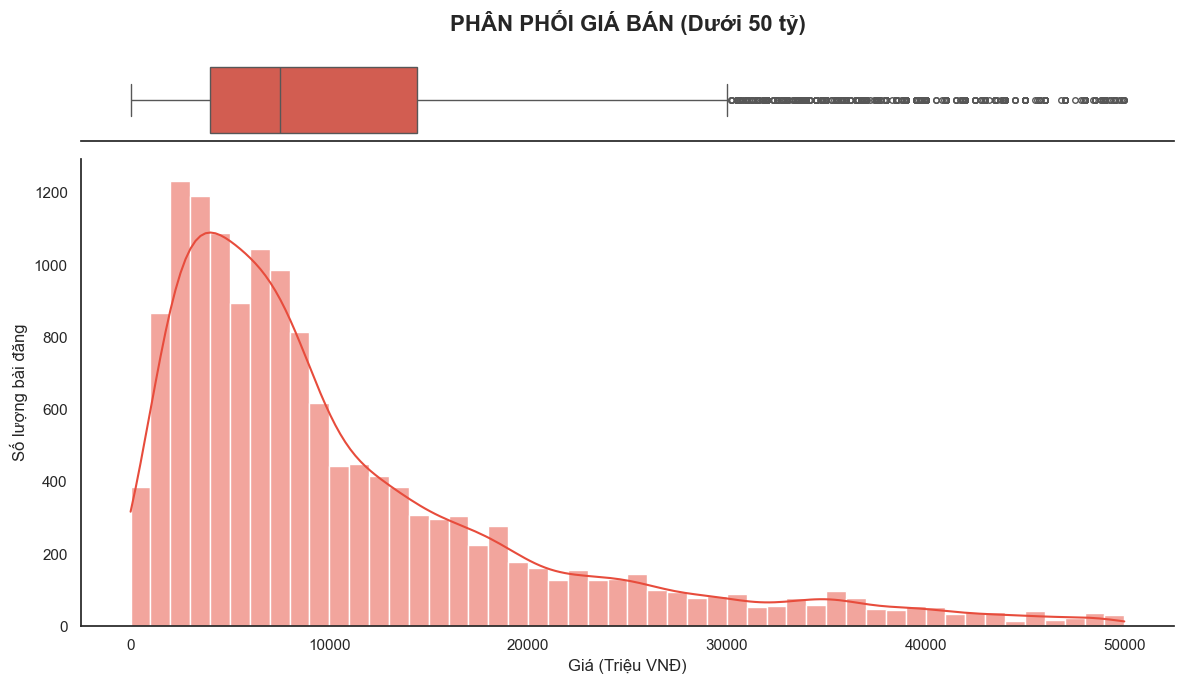

In [22]:
# Lọc các bất động sản dưới 50 tỷ (50,000 triệu) để quan sát vùng giá phổ biến
sale_prices = df_sale[df_sale['price'] < 50000]['price'].dropna()
plot_dist_with_boxplot(sale_prices, 'PHÂN PHỐI GIÁ BÁN (Dưới 50 tỷ)', '#e74c3c', 'Triệu VNĐ')

## Biểu đồ nhiệt

In [ ]:
import folium
from folium.plugins import HeatMap

# 1. Chuẩn bị dữ liệu (Lọc tọa độ sạch)
def clean_geo_data(df_input):
    temp_df = df_input.copy()
    temp_df['latitude'] = pd.to_numeric(temp_df['latitude'], errors='coerce')
    temp_df['longitude'] = pd.to_numeric(temp_df['longitude'], errors='coerce')
    return temp_df.dropna(subset=['latitude', 'longitude'])

# Sử dụng df_sale hoặc df tổng tùy nhu cầu của bạn
df_geo = clean_geo_data(df_sale) 

# 2. Thiết lập bản đồ nền Google Maps tiếng Việt
# hl=vi giúp hiển thị tên địa danh bằng tiếng Việt
google_maps_vi_url = 'https://mt1.google.com/vt/lyrs=m&hl=vi&x={x}&y={y}&z={z}'

# Tính toán vị trí trung tâm dựa trên dữ liệu của bạn
center_lat = df_geo['latitude'].mean()
center_lon = df_geo['longitude'].mean()

m_final = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=11, 
    tiles=google_maps_vi_url, 
    attr='Dữ liệu © Google Maps Việt Nam'
)

# 3. Tạo dữ liệu HeatMap từ tọa độ bất động sản
# Bạn có thể thêm trọng số (weight) là giá nếu muốn nhìn theo giá
heat_data = [[row['latitude'], row['longitude']] for index, row in df_geo.iterrows()]

# 4. Thêm lớp HeatMap vào bản đồ
HeatMap(
    heat_data, 
    radius=15, 
    blur=10, 
    min_opacity=0.5,
    name='Mật độ tin đăng'
).add_to(m_final)

# 5. Thêm Marker khẳng định chủ quyền Hoàng Sa & Trường Sa
# Điều này cực kỳ quan trọng để bản đồ hiển thị đúng tinh thần Việt Nam
folium.Marker(
    location=[16.565141, 112.641903],
    popup='Quần đảo Hoàng Sa (Việt Nam)',
    icon=folium.Icon(color='red', icon='flag')
).add_to(m_final)

folium.Marker(
    location=[10.725116, 115.842338],
    popup='Quần đảo Trường Sa (Việt Nam)',
    icon=folium.Icon(color='red', icon='flag')
).add_to(m_final)

# 6. Thêm bộ lọc (nếu sau này bạn muốn thêm nhiều lớp khác)
folium.LayerControl().add_to(m_final)

# Lưu kết quả
m_final.save('heatmap_bat_dong_san.html')

Đã tạo xong bản đồ Heatmap với đầy đủ Hoàng Sa, Trường Sa và nhãn tiếng Việt!


## Dự án nổi bật

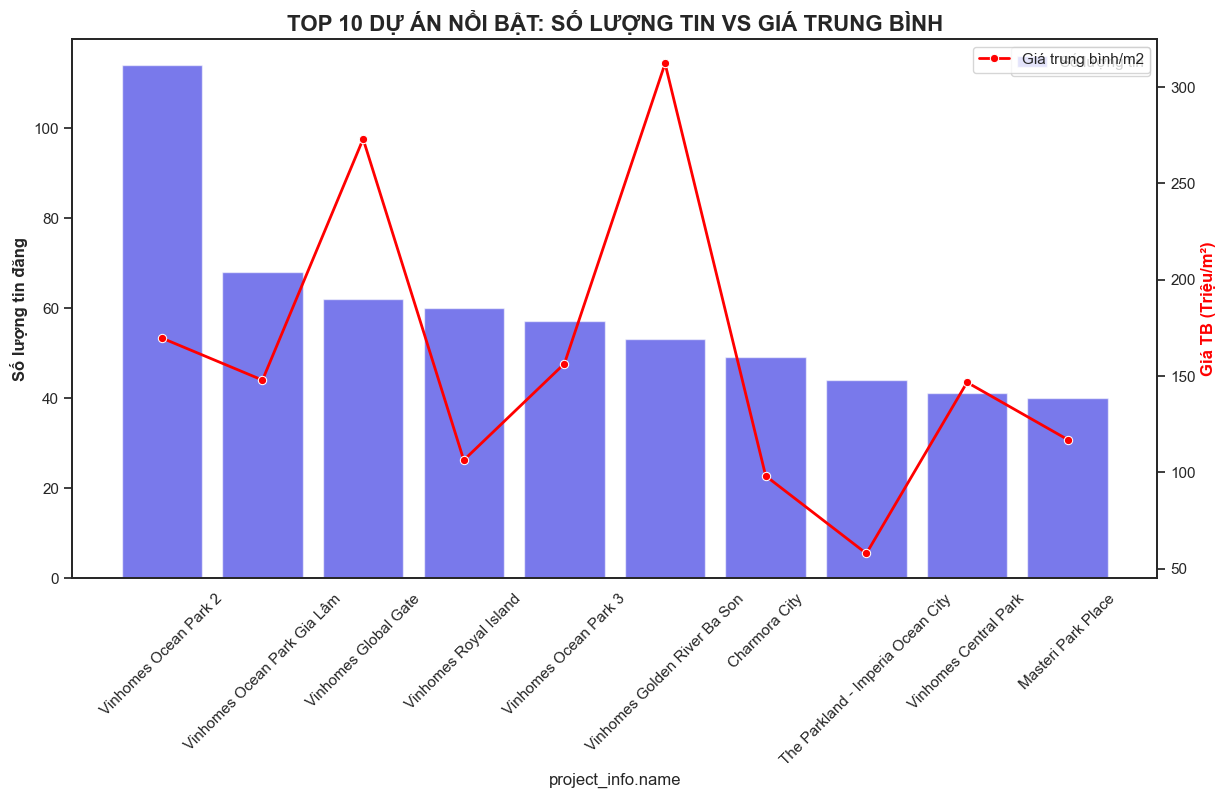

In [26]:
# Lấy top 10 dự án có nhiều tin đăng nhất
top_projects = df_sale['project_info.name'].value_counts().head(11)
if 'None' in top_projects or None in top_projects:
    top_projects = top_projects.drop(labels=[None], errors='ignore')
top_projects = top_projects.head(10)

# Tính giá trung bình cho mỗi dự án trong top
project_prices = df_sale[df_sale['project_info.name'].isin(top_projects.index)].groupby('project_info.name')['price_per_spm'].mean().sort_values(ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Vẽ cột số lượng tin đăng
sns.barplot(x=top_projects.index, y=top_projects.values, ax=ax1, alpha=0.6, color='blue', label='Số lượng tin')
ax1.set_ylabel('Số lượng tin đăng', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Vẽ đường giá trung bình
ax2 = ax1.twinx()
sns.lineplot(x=project_prices.index, y=project_prices.values, ax=ax2, marker='o', color='red', linewidth=2, label='Giá trung bình/m2')
ax2.set_ylabel('Giá TB (Triệu/m²)', fontsize=12, fontweight='bold', color='red')

plt.title('TOP 10 DỰ ÁN NỔI BẬT: SỐ LƯỢNG TIN VS GIÁ TRUNG BÌNH', fontsize=16, fontweight='bold')
plt.show()

## Phân phối giá của 2 thành phố lớn

C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\53011686.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\53011686.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


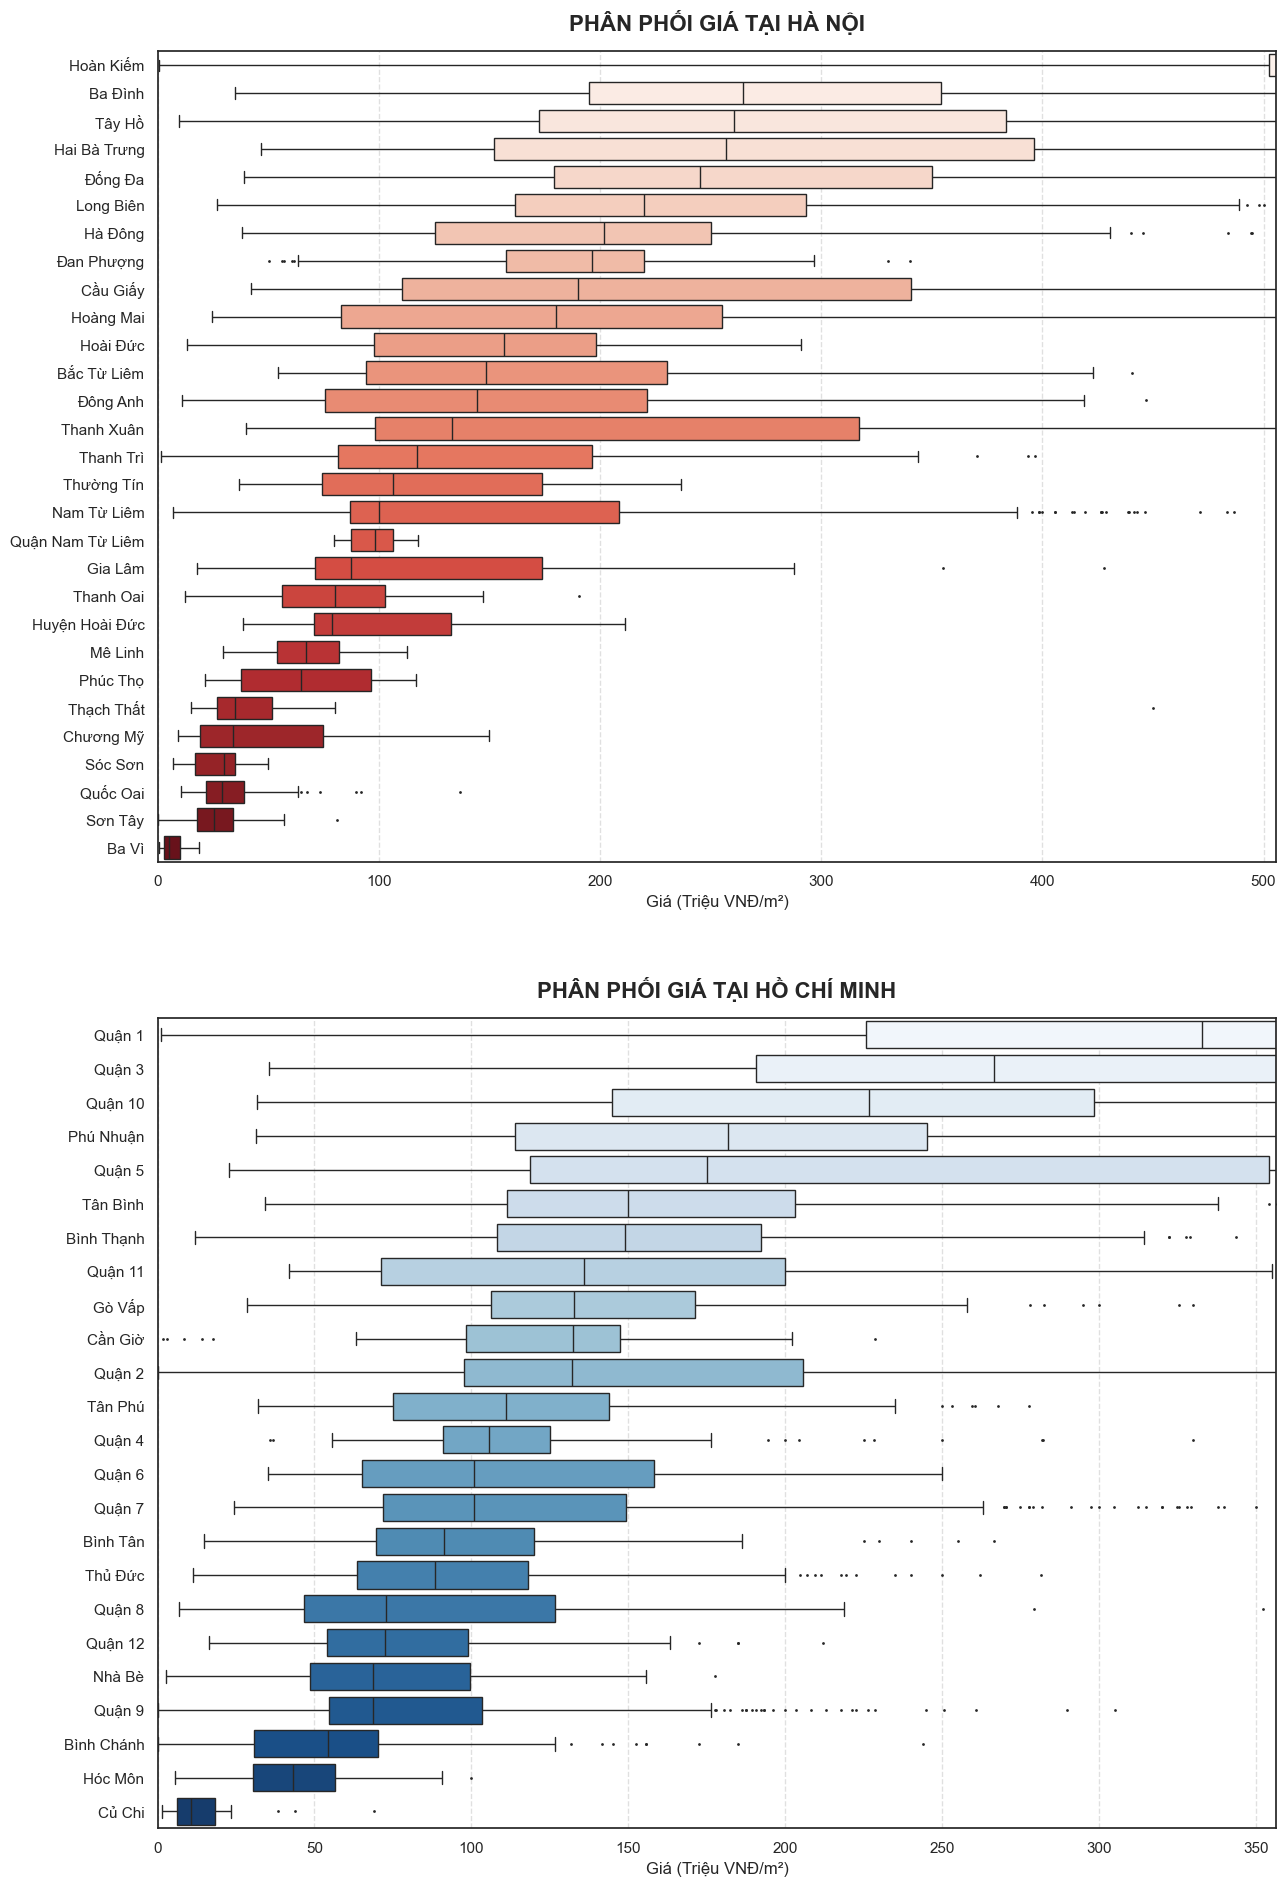

In [27]:
df_sale['province_clean'] = df_sale['province'].str.replace('Thành phố ', '').str.replace('TP. ', '').str.strip()

def plot_district_prices_fixed(city_name, ax, color_palette):
    # 1. Lọc dữ liệu
    city_df = df_sale[df_sale['province_clean'].str.contains(city_name, case=False, na=False)].copy()
    
    if city_df.empty:
        ax.set_title(f"Không có dữ liệu cho {city_name}")
        return

    # 2. Lọc bỏ các Quận có quá ít tin đăng (ví dụ dưới 10 tin) để biểu đồ sạch hơn
    district_counts = city_df['district'].value_counts()
    top_districts = district_counts[district_counts > 10].index
    city_df = city_df[city_df['district'].isin(top_districts)]

    # 3. Sắp xếp thứ tự Quận theo giá trung vị
    order = city_df.groupby('district')['price_per_spm'].median().sort_values(ascending=False).index
    
    # 4. Vẽ biểu đồ NGANG (y='district') để tránh đè chữ
    sns.boxplot(
        data=city_df, 
        y='district', 
        x='price_per_spm', 
        order=order, 
        ax=ax, 
        palette=color_palette,
        fliersize=1 # Giảm kích thước điểm nhiễu để nhìn đỡ rối
    )
    
    # Giới hạn trục X (giá) ở mức 95th percentile
    ax.set_xlim(0, city_df['price_per_spm'].quantile(0.95))
    
    ax.set_title(f'PHÂN PHỐI GIÁ TẠI {city_name.upper()}', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Giá (Triệu VNĐ/m²)', fontsize=12)
    ax.set_ylabel('', fontsize=12) # Bỏ chữ "district" vì tên quận đã rõ ràng
    ax.grid(axis='x', linestyle='--', alpha=0.6) # Thêm lưới dọc để dễ gióng giá

# Khởi tạo khung hình: Tăng chiều cao (figsize) để các dòng không bị dính nhau
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 20)) 

plot_district_prices_fixed('Hà Nội', ax1, 'Reds')
plot_district_prices_fixed('Hồ Chí Minh', ax2, 'Blues')

plt.tight_layout(pad=4.0) # Tăng khoảng cách giữa 2 biểu đồ
plt.show()

## Phân phối giá theo hướng nhà

In [28]:

import plotly.io as pio 
pio.renderers.default = "browser" # mở biểu đồ trong trình duyệt
import plotly.express as px

# 1. Thống kê số lượng theo hướng
orientation_counts = df_sale['spec.orientation'].value_counts().reset_index()
orientation_counts.columns = ['Hướng', 'Số lượng']

# 2. Tính giá trung bình theo hướng
orientation_price = df_sale.groupby('spec.orientation')['price_per_spm'].median().reset_index()
orientation_price.columns = ['Hướng', 'Giá trung vị/m²']

# Trộn 2 bảng lại
orientation_df = orientation_counts.merge(orientation_price, on='Hướng')

# 3. Vẽ biểu đồ Rose Chart (số lượng tin theo hướng)
fig = px.bar_polar(orientation_df, r='Số lượng', theta='Hướng',
                   color='Giá trung vị/m²', template="plotly_white",
                   color_continuous_scale=px.colors.sequential.Reds,
                   title='PHÂN BỔ HƯỚNG NHÀ & MẶT BẰNG GIÁ (Màu đậm = Giá cao)')
fig.show()

## Top 10 đặc trưng ảnh hưởng mạnh đến giá

In [29]:

def clean_technical_specs(x):
    if pd.isna(x) or str(x).strip() == "": return np.nan
    text = str(x).lower().strip()
    
    # Xử lý riêng cho cột 'Số tầng' (num_floor)
    # Ví dụ: "1 trệt 2 lầu" -> 3 tầng, "trệt" -> 1 tầng
    if 'trệt' in text or 'lầu' in text or 'tầng' in text:
        # Đếm tổng các số xuất hiện (ví dụ "1 trệt 2 lầu" lấy 1+2 = 3)
        nums = re.findall(r'\d+', text)
        if nums:
            return sum(int(n) for n in nums)
        return 1 if 'trệt' in text else np.nan

    # Xử lý cho các cột khác (Rộng đường, Mặt tiền, Phòng ngủ...)
    # Quy tắc: [.] là hàng nghìn, [,] là thập phân (theo yêu cầu của bạn ở trên)
    text = text.replace('.', '')
    text = text.replace(',', '.')
    
    # Trích xuất số thực đầu tiên tìm thấy
    match = re.search(r"[-+]?\d*\.\d+|\d+", text)
    if match:
        return float(match.group())
    return np.nan

# Danh sách các cột kỹ thuật cần làm sạch
spec_cols = [
    'spec.front_width', 'spec.road_width', 'spec.num_floor', 
    'spec.bedroom', 'spec.bathroom', 'contact_info.listings', 'project_info.listing_count'
]

for col in spec_cols:
    if col in df_sale.columns:
        df_sale[col] = df_sale[col].apply(clean_technical_specs)

# Chuyển đổi cột 'verified' sang 0 và 1 để tính tương quan
if 'verified' in df_sale.columns:
    df_sale['verified_num'] = df_sale['verified'].map({True: 1, False: 0}).fillna(0)

print("Đã làm sạch xong các thông số kỹ thuật và chuẩn hóa dữ liệu số.")

Đã làm sạch xong các thông số kỹ thuật và chuẩn hóa dữ liệu số.


C:\Users\Admin\AppData\Local\Temp\ipykernel_5764\2310000174.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




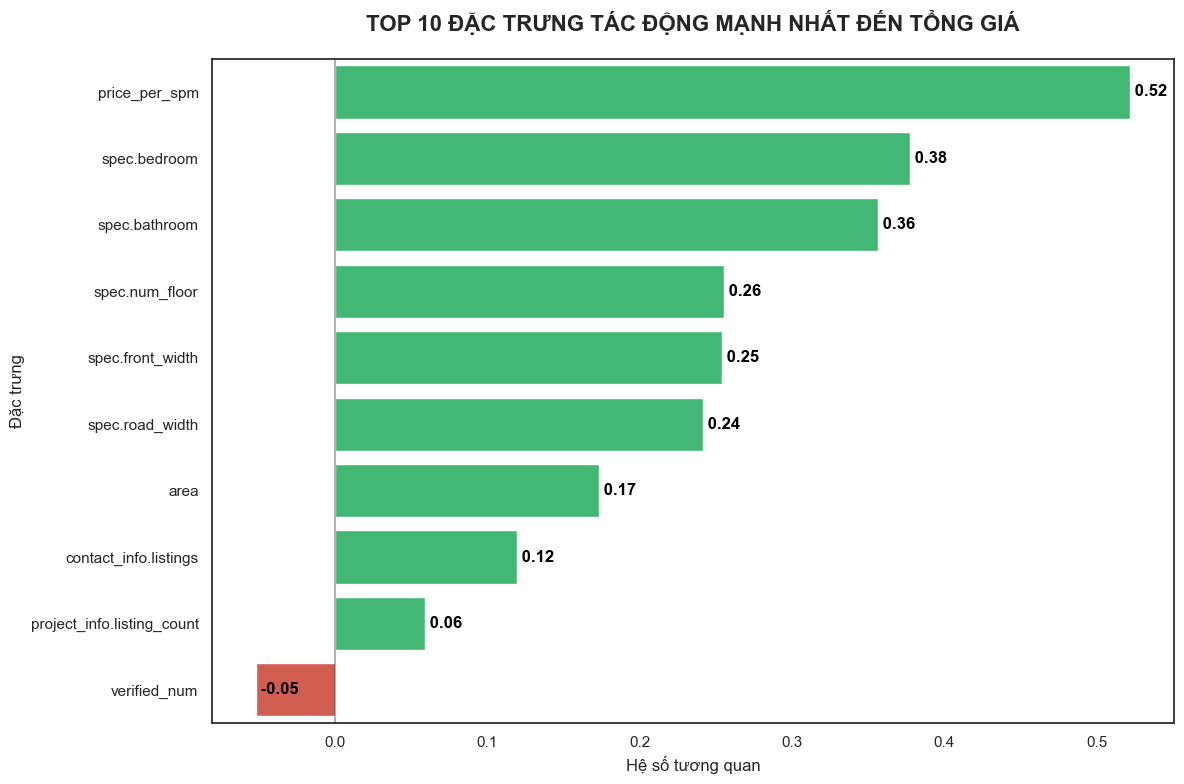

In [30]:
# 1. Chọn các cột số đã làm sạch
features_to_check = [
    'price', 'area', 'price_per_spm', 'spec.front_width', 
    'spec.road_width', 'spec.num_floor', 'spec.bedroom', 
    'spec.bathroom', 'contact_info.listings', 'project_info.listing_count', 'verified_num'
]

# 2. Tính tương quan (Pearson)
# Chúng ta dùng .dropna() để đảm bảo tính toán trên các dòng có đủ dữ liệu
corr_matrix = df_sale[features_to_check].dropna(subset=['price']).corr()

# 3. Lấy Top 10 đặc trưng ảnh hưởng đến 'price' (bỏ chính nó)
price_corr = corr_matrix['price'].drop('price', errors='ignore')
# Sắp xếp theo giá trị tuyệt đối để lấy mức độ ảnh hưởng mạnh nhất
top_10_features = price_corr.abs().sort_values(ascending=False).head(10)
top_10_data = price_corr[top_10_features.index] # Lấy giá trị gốc để biết âm hay dương

# 4. Vẽ biểu đồ
plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_10_data.values]
sns.barplot(x=top_10_data.values, y=top_10_data.index, palette=colors)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('TOP 10 ĐẶC TRƯNG TÁC ĐỘNG MẠNH NHẤT ĐẾN TỔNG GIÁ', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)

# Thêm ghi chú
for i, v in enumerate(top_10_data.values):
    plt.text(v, i, f' {v:.2f}', va='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()